In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

In [2]:
# Load the dataset
df = pd.read_csv("Datasets/bit.csv")

df

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,less than 40,Male,yes,no,more than half an hr,25.0,no,no,8,6,no,often,sometimes,normal,0.0,0,not much,yes
948,60 or older,Male,yes,yes,more than half an hr,27.0,no,no,6,5,yes,occasionally,sometimes,high,0.0,0,quite often,yes
949,60 or older,Male,no,yes,none,23.0,no,no,6,5,yes,occasionally,sometimes,high,0.0,0,not much,no
950,60 or older,Male,no,yes,less than half an hr,27.0,no,yes,6,5,yes,occasionally,very often,high,0.0,0,not much,no


In [3]:
# Drop NaN value
print("Any null value:", any(df.isnull()))
print("Any NaN value:", any(df.isna()))
print("Before Droping NA Number of Rows:", len(df))

df = df.dropna()
print("After Droping NA Number of Rows:", len(df))

# Reset the Index after dropping NaN
df = df.reset_index(drop=True)

# Encode textual columns
le = LabelEncoder()
for each in ['Age', 'Gender', 'Family_Diabetes', 'highBP', 'PhysicallyActive', 'Smoking', 'Alcohol', 'RegularMedicine', 'JunkFood', 'Stress', 'BPLevel', 'Pdiabetes', 'UriationFreq', 'Diabetic']:
    df[each] = le.fit_transform(df[each])

df.tail()

Any null value: True
Any NaN value: True
Before Droping NA Number of Rows: 952
After Droping NA Number of Rows: 905


,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
900,3,1,1,0,1,25.0,0,0,8,6,0,2,2,4,0.0,0,0,1
901,2,1,1,1,1,27.0,0,0,6,5,1,1,2,2,0.0,0,1,1
902,2,1,0,1,2,23.0,0,0,6,5,1,1,2,2,0.0,0,0,0
903,2,1,0,1,0,27.0,0,1,6,5,1,1,3,2,0.0,0,0,0
904,2,0,1,1,3,30.0,0,0,7,4,1,1,2,2,2.0,0,1,1


In [4]:
# Separate features and target variable
X = df.drop(columns=['Diabetic']).values
y = df['Diabetic'].values

# Normalize numerical features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [5]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [6]:
# Split data into training and testing sets (avoid scaling entire data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [7]:
# Reshape for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_lstm = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [8]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional, Dense, Dropout, BatchNormalization, Concatenate, Flatten

# Assuming your input data is in the format (samples, features)
# Define the inputs
inputs = Input(shape=(X_lstm.shape[1], 1))

# Dense layers
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Recurrent layers
x_lstm = Bidirectional(LSTM(64, return_sequences=True))(x)
x_gru = Bidirectional(GRU(64, return_sequences=True))(x)

# Concatenate LSTM and GRU outputs
x = Concatenate()([x_lstm, x_gru])
x = Flatten()(x)

# Dense layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=100)
# Train the model
history = model.fit(X_train_lstm, y_train, epochs=2000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_lstm, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9372 - loss: 0.1420 - val_accuracy: 0.9563 - val_loss: 0.0881
Epoch 2/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9683 - loss: 0.0923 - val_accuracy: 0.9660 - val_loss: 0.0848
Epoch 3/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9720 - loss: 0.0821 - val_accuracy: 0.9515 - val_loss: 0.0944
Epoch 4/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9536 - loss: 0.0915 - val_accuracy: 0.9417 - val_loss: 0.0911
Epoch 5/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9695 - loss: 0.0771 - val_accuracy: 0.9417 - val_loss: 0.0974
Epoch 6/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9685 - loss: 0.0785 - val_accuracy: 0.9466 - val_loss: 0.0883
Epoch 7/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9676 - loss: 0.0768 - val_accuracy: 0.9320 - val_loss: 0.2121
Epoch 8/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9731 - loss: 0.0628 - val_accu

In [10]:
# Save the entire model to a file
model.save('Results/bit/bilstm_model.keras')
# Save only the model's weights to a file
model.save_weights('Results/bit/bilstm_model.weights.h5')
# Save only the model's architecture to a JSON file
model_json = model.to_json()
with open('Results/bit/bistlm_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save X_test as a NumPy array
np.save('Results/bit/bilstm_X_test.npy', X_test_lstm)

# Save y_test as a NumPy array
np.save('Results/bit/bilstm_y_test.npy', y_test)

# Get the training and validation accuracy and loss values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Save the accuracy and loss values as NumPy arrays
np.save('Results/bit/bilstm_train_acc.npy', train_acc)
np.save('Results/bit/bilstm_val_acc.npy', val_acc)
np.save('Results/bit/bilstm_train_loss.npy', train_loss)
np.save('Results/bit/bilstm_val_loss.npy', val_loss)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


<Figure size 500x300 with 0 Axes>

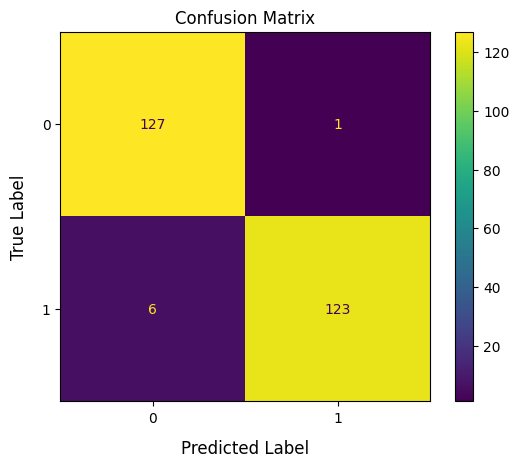

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test) > 0.5
y_pred = y_pred.astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix', fontsize=12, fontweight='normal')
plt.xlabel('Predicted Label', fontsize=12, labelpad=10)
plt.ylabel('True Label', fontsize=12, labelpad=10)
plt.show()
# Set the title and labels

In [12]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       128
           1       0.99      0.95      0.97       129

    accuracy                           0.97       257
   macro avg       0.97      0.97      0.97       257
weighted avg       0.97      0.97      0.97       257



In [13]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred)

print(f"AUC Score: {auc_score:.2f}")

AUC Score: 0.97


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


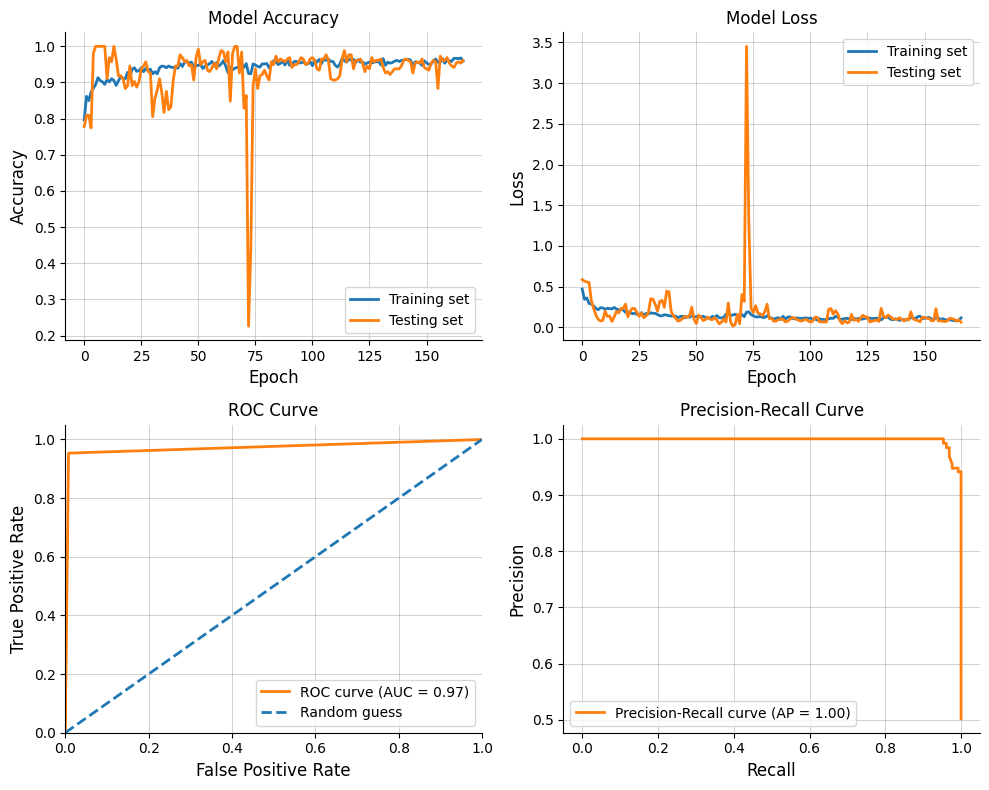

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Set background color and grid style for all subplots
fig.set_facecolor('white')
for ax in axes.flat:
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Plot accuracy
axes[0, 0].plot(history.history['accuracy'], linewidth=2, color='#1f77b4', label='Training set')
axes[0, 0].plot(history.history['val_accuracy'], linewidth=2, color='#ff7f0e', label='Testing set')
axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='normal')
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].legend(loc='lower right', fontsize=10)
axes[0, 0].tick_params(axis='both', which='major', labelsize=10)

# Plot loss
axes[0, 1].plot(history.history['loss'], linewidth=2, color='#1f77b4', label='Training set')
axes[0, 1].plot(history.history['val_loss'], linewidth=2, color='#ff7f0e', label='Testing set')
axes[0, 1].set_title('Model Loss', fontsize=12, fontweight='normal')
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].legend(loc='upper right', fontsize=10)
axes[0, 1].tick_params(axis='both', which='major', labelsize=10)

# Compute the ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
axes[1, 0].plot(fpr, tpr, color='#ff7f0e', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1, 0].plot([0, 1], [0, 1], color='#1f77b4', linewidth=2, linestyle='--', label='Random guess')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[1, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[1, 0].set_title('ROC Curve', fontsize=12, fontweight='normal')
axes[1, 0].tick_params(axis='both', which='major', labelsize=10)
axes[1, 0].legend(loc='lower right', fontsize=10)

# Compute Precision-Recall curve and average precision score
y_score = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

# Plot Precision-Recall curve
axes[1, 1].plot(recall, precision, color='#ff7f0e', linewidth=2, label=f'Precision-Recall curve (AP = {ap:.2f})')
axes[1, 1].set_xlabel('Recall', fontsize=12)
axes[1, 1].set_ylabel('Precision', fontsize=12)
axes[1, 1].set_title('Precision-Recall Curve', fontsize=12, fontweight='normal')
axes[1, 1].tick_params(axis='both', which='major', labelsize=10)
axes[1, 1].legend(loc="lower left", fontsize=10)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

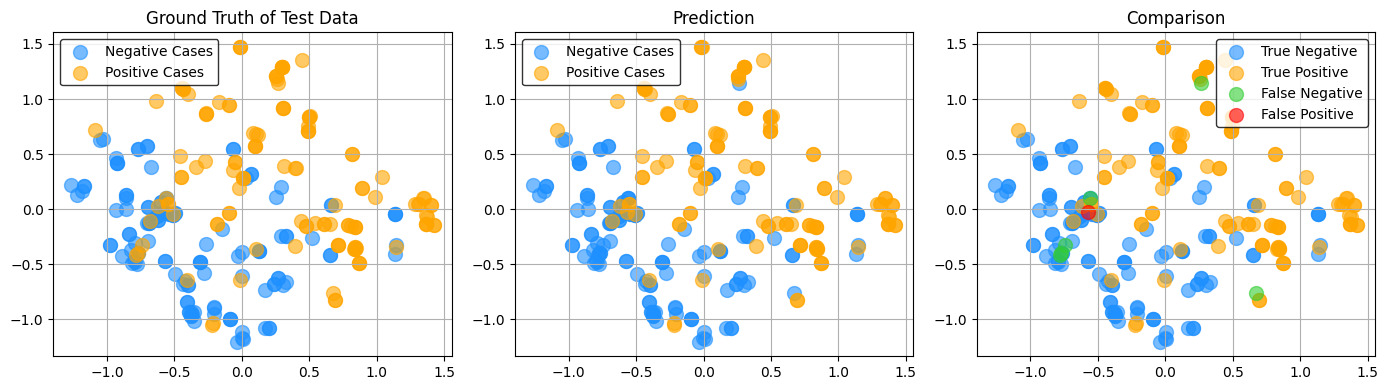

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pca_plot(test_x_scaled, test_y, test_y_pred, size=100, markersize=1):
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(test_x_scaled)

    true_np = np.hstack((x_pca, test_y.reshape(len(test_y), 1)))
    pred_np = np.hstack((x_pca, test_y_pred.reshape(len(test_y_pred), 1)))

    column_true = ['pc_0', 'pc_1', 'true']
    column_pred = ['pc_0', 'pc_1', 'pred']

    true_df = pd.DataFrame(data=true_np, columns=column_true)
    pred_df = pd.DataFrame(data=pred_np, columns=column_pred)

    true_df_0 = true_df[true_df['true'] == 0]
    true_df_1 = true_df[true_df['true'] == 1]
    true_x_0 = true_df_0.iloc[:, :-1].to_numpy()
    true_x_1 = true_df_1.iloc[:, :-1].to_numpy()

    pred_df_0 = pred_df[pred_df['pred'] == 0]
    pred_df_1 = pred_df[pred_df['pred'] == 1]
    pred_x_0 = pred_df_0.iloc[:, :-1].to_numpy()
    pred_x_1 = pred_df_1.iloc[:, :-1].to_numpy()

    join_df = true_df.join(pred_df['pred'], rsuffix='_pred')

    correct_df = join_df[join_df['true'] == join_df['pred']]
    wrong_df = join_df[join_df['true'] != join_df['pred']]

    correct_df_0 = correct_df[correct_df['true'] == 0]
    correct_df_1 = correct_df[correct_df['true'] == 1]
    correct_x_0 = correct_df_0.iloc[:, :-2].to_numpy()
    correct_x_1 = correct_df_1.iloc[:, :-2].to_numpy()

    fn_df = wrong_df[wrong_df['pred'] == 0]
    fp_df = wrong_df[wrong_df['pred'] == 1]
    fn_x = fn_df.iloc[:, :-2].to_numpy()
    fp_x = fp_df.iloc[:, :-2].to_numpy()

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

    # Plot Ground Truth
    ax1.scatter(true_x_0[:, 0], true_x_0[:, 1], c='dodgerblue', s=size, alpha=0.6, label='Negative Cases')
    ax1.scatter(true_x_1[:, 0], true_x_1[:, 1], c='orange', s=size, alpha=0.6, label='Positive Cases')
    ax1.legend(markerscale=markersize, loc='best', frameon=True, facecolor='white', edgecolor='black')
    ax1.set_title('Ground Truth of Test Data', fontsize=12)
    # ax1.set_xlabel('Principal Component 1', fontsize=12)
    # ax1.set_ylabel('Principal Component 2', fontsize=12)
    ax1.grid(True)

    # Plot Predictions
    ax2.scatter(pred_x_0[:, 0], pred_x_0[:, 1], c='dodgerblue', s=size, alpha=0.6, label='Negative Cases')
    ax2.scatter(pred_x_1[:, 0], pred_x_1[:, 1], c='orange', s=size, alpha=0.6, label='Positive Cases')
    ax2.legend(markerscale=markersize, loc='best', frameon=True, facecolor='white', edgecolor='black')
    ax2.set_title('Prediction', fontsize=12)
    # ax2.set_xlabel('Principal Component 1', fontsize=12)
    # ax2.set_ylabel('Principal Component 2', fontsize=12)
    ax2.grid(True)

    # Plot Comparison
    ax3.scatter(correct_x_0[:, 0], correct_x_0[:, 1], c='dodgerblue', s=size, alpha=0.6, label='True Negative')
    ax3.scatter(correct_x_1[:, 0], correct_x_1[:, 1], c='orange', s=size, alpha=0.6, label='True Positive')
    ax3.scatter(fn_x[:, 0], fn_x[:, 1], c='limegreen', s=size, alpha=0.6, label='False Negative')
    ax3.scatter(fp_x[:, 0], fp_x[:, 1], c='red', s=size, alpha=0.6, label='False Positive')
    ax3.legend(markerscale=markersize, loc='best', frameon=True, facecolor='white', edgecolor='black')
    ax3.set_title('Comparison', fontsize=12)
    # ax3.set_xlabel('Principal Component 1', fontsize=12)
    # ax3.set_ylabel('Principal Component 2', fontsize=12)
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
pca_plot(X_test, y_test, y_pred, size=100, markersize=1)
